In [1]:
import numpy as np 
import os
import scipy.io

SAMPLE_LENGTH = 1024

def import_file(bearing = 'DE', fault_type = 0, load_level = 0, sensor = 'all', print_infor = False, sample_length = 1024):
    """
    Import data 

    Args:
        bearing (str): 'DE' or 'FE'
        fault_type (int): label from 0 to 9 
        load_level (int): 0 HP, 1 HP, 2 HP
        sensor (str) : 'DE', 'FE', 'BA', 'all'

        output: data (numpy array)
    """
    if bearing == 'DE': 
        base_data_directory = 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/'
    else: 
        base_data_directory = 'CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/'

    fault_dict = {
        0 : 'Normal/',
        1 : 'B/007/',
        2 : 'B/014/',
        3 : 'B/021/',
        4 : 'IR/007/',
        5 : 'IR/014/',
        6 : 'IR/021/',
        7 : 'OR/007/@6/',
        8 : 'OR/014/',
        9 : 'OR/021/@6/'
    }
    load_level_dict = {
        0 : '_0',
        1 : '_1',
        2 : '_2',
    }

    file_path = os.path.join(base_data_directory, fault_dict[fault_type])
    full_file_path = None

    try:
        file_list = os.listdir(file_path)
        for file in file_list: 
            full_path = os.path.join(file_path, file)
            if os.path.isfile(full_path): 
                if load_level_dict[load_level] in file: 
                    full_file_path = full_path

            if full_file_path:
                break
    except: 
        print('File path not exsits')

    data = np.array([])
    data_import = None
    mat_data = scipy.io.loadmat(full_file_path)
    keys_in_file = list(mat_data.keys())

    for key in keys_in_file: 
        if sensor == 'all' and ('DE' in key or 'FE' in key or 'BA' in key):
            data_import = mat_data[key].flatten()
            length = (len(data_import) // sample_length) * sample_length
            data_import = data_import[:length]
            data = np.append(data, data_import)
            if print_infor: 
                print('================= Import data =====================')
                print(f' - Process file: {full_file_path}')
                print(f' - Key: {key}')
                print(f' - Data length: {len(data)/sample_length}')
                print('===================================================')
        elif sensor in key:
            data = mat_data[key].flatten()
            length = (len(data)//sample_length) * sample_length
            data = data[:length]
            if print_infor: 
                print('================= Import data =====================')
                print(f' - Process file: {full_file_path}')
                print(f' - Key: {key}')
                print(f' - Data length: {len(data)/sample_length}')
                print('===================================================')
            break

    
    return data

def import_data(bearing = 'DE', load_level = 0, sensor = 'all', sample_length = 1024):
    X_data = []
    Y_data = []

    for fault_type_label in range(10):
        data = import_file(bearing, fault_type_label, load_level, sensor, False, sample_length)
        data_reshaped = data.reshape(-1, sample_length)
        labels = np.full(data_reshaped.shape[0], fault_type_label)
        X_data.append(data_reshaped)
        Y_data.append(labels)

    final_X_data = np.concatenate(X_data, axis=0)
    final_Y_data = np.concatenate(Y_data, axis=0)

    return final_X_data, final_Y_data

In [2]:
X_data, Y_data = import_data(load_level= 1, sensor = 'FE')
print(X_data.shape)
print(Y_data.shape)

(1539, 1024)
(1539,)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train_, Y_test_ = train_test_split(X_data, Y_data, test_size= 0.20)
print(X_train.shape, X_test.shape)
print(Y_train_.shape, Y_test_.shape)

(1231, 1024) (308, 1024)
(1231,) (308,)


In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

L_E = LabelEncoder()
L_E.fit_transform(Y_data)
labels = L_E.classes_
print(f'Classes: {labels}')

Classes: [0 1 2 3 4 5 6 7 8 9]


In [5]:
def one_hot_encoding(data):
  L_E = LabelEncoder()
  integer_encoded = L_E.fit_transform(data)  
  onehot_encoder = OneHotEncoder(sparse_output=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  one_hot_encoded_data = onehot_encoder.fit_transform(integer_encoded)
  return one_hot_encoded_data

In [6]:
Y_train = one_hot_encoding(Y_train_.ravel())
Y_test = one_hot_encoding(Y_test_.ravel())

In [7]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(1231, 1024) (308, 1024)
(1231, 10) (308, 10)


In [8]:
model_width = 64
num_channel = 1 
problem_type = 'Classification'
class_number = Y_train.shape[1]

In [9]:
from MobileNet_1DCNN import MobileNet

Classification_Model = MobileNet(SAMPLE_LENGTH, num_channel,  model_width, problem_type= problem_type, output_nums=class_number).MobileNet_v3_Small()
Classification_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse','accuracy'])

Classification_Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 512, 16)              64        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 16)              64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 tf.math.add (TFOpLambda)    (None, 512, 16)              0         ['batch_normalization[0][0

In [10]:
import tensorflow as tf

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min'), 
             tf.keras.callbacks.ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Classification_Model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.5915 - mse: 0.0651 - accuracy: 0.4675
Epoch 1: val_loss improved from inf to 2.32693, saving model to Saved_Model.h5


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 48s 521ms/step - loss: 1.5915 - mse: 0.0651 - accuracy: 0.4675 - val_loss: 2.3269 - val_mse: 0.0906 - val_accuracy: 0.0810
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.9356 - mse: 0.0415 - accuracy: 0.6636
Epoch 2: val_loss did not improve from 2.32693
31/31 [==============================] - 13s 415ms/step - loss: 0.9356 - mse: 0.0415 - accuracy: 0.6636 - val_loss: 2.5082 - val_mse: 0.0940 - val_accuracy: 0.0810
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.9124 - mse: 0.0384 - accuracy: 0.6921
Epoch 3: val_loss did not improve from 2.32693
31/31 [==============================] - 13s 407ms/step - loss: 0.9124 - mse: 0.0384 - accuracy: 0.6921 - val_loss: 2.6196 - val_mse: 0.0964 - val_accuracy: 0.0810
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.5100 - mse: 0.0260 - accuracy: 0.7835
Epoch 4: val_loss did not improve from 2.32693
31/31 [==============================] - 12

In [11]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, average_precision_score
sns.set_theme(style="whitegrid")

In [12]:
Predictions = Classification_Model.predict(X_test, verbose=1)
print(Predictions.shape)

10/10 [==============================] - 3s 87ms/step
(308, 10)


In [13]:
Error = mean_absolute_error(Y_test, Predictions)
print(f"MAE: {Error}")

MAE: 0.007385658143763016


In [14]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


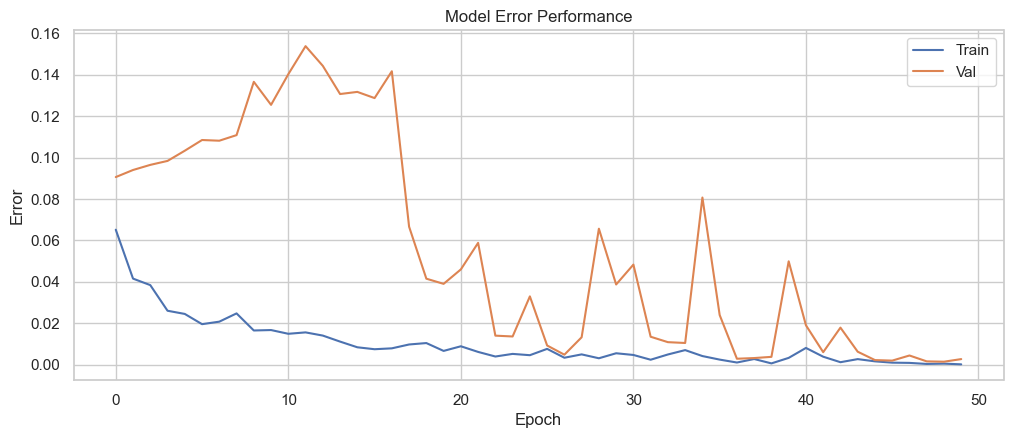

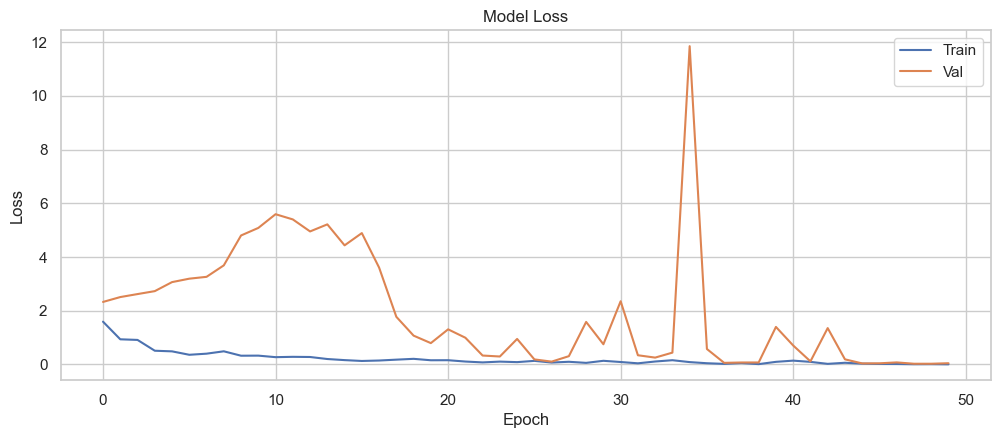

In [15]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

In [16]:
prediction_shape = Predictions.shape
prediction_length = prediction_shape[0]
Y_Preds = np.zeros((prediction_length, 1), dtype=int)
#
for i in range(0, prediction_length):
  prediction = Predictions[i]
  x = np.where(prediction == np.max(prediction))
  x = int(x[0])
  Y_Preds[i] = x

Y_Preds.shape

C:\Users\Admin\AppData\Local\Temp\ipykernel_2156\888271762.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = int(x[0])


(308, 1)

In [17]:
print('-------------------------------------------')
print('Raw Confusion Matrix')
print(confusion_matrix(Y_test_, Y_Preds, normalize=None))
print('-------------------------------------------')
print('Normalized Confusion Matrix')
print(confusion_matrix(Y_test_, Y_Preds, normalize='true'))
print('-------------------------------------------')

-------------------------------------------
Raw Confusion Matrix
[[92  0  0  3  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  2  0 25  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0]
 [ 0  1  0  1  0 22  0  0  0  0]
 [ 0  0  0  0  0  0 22  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0 21  0]
 [ 0  0  0  0  0  0  0  0  0 24]]
-------------------------------------------
Normalized Confusion Matrix
[[0.96842105 0.         0.         0.03157895 0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.07407407 0.         0.92592593 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.       

In [18]:
# Use the numeric labels or replace with real-class names. But be careful about their respective sequence
labels = ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7']

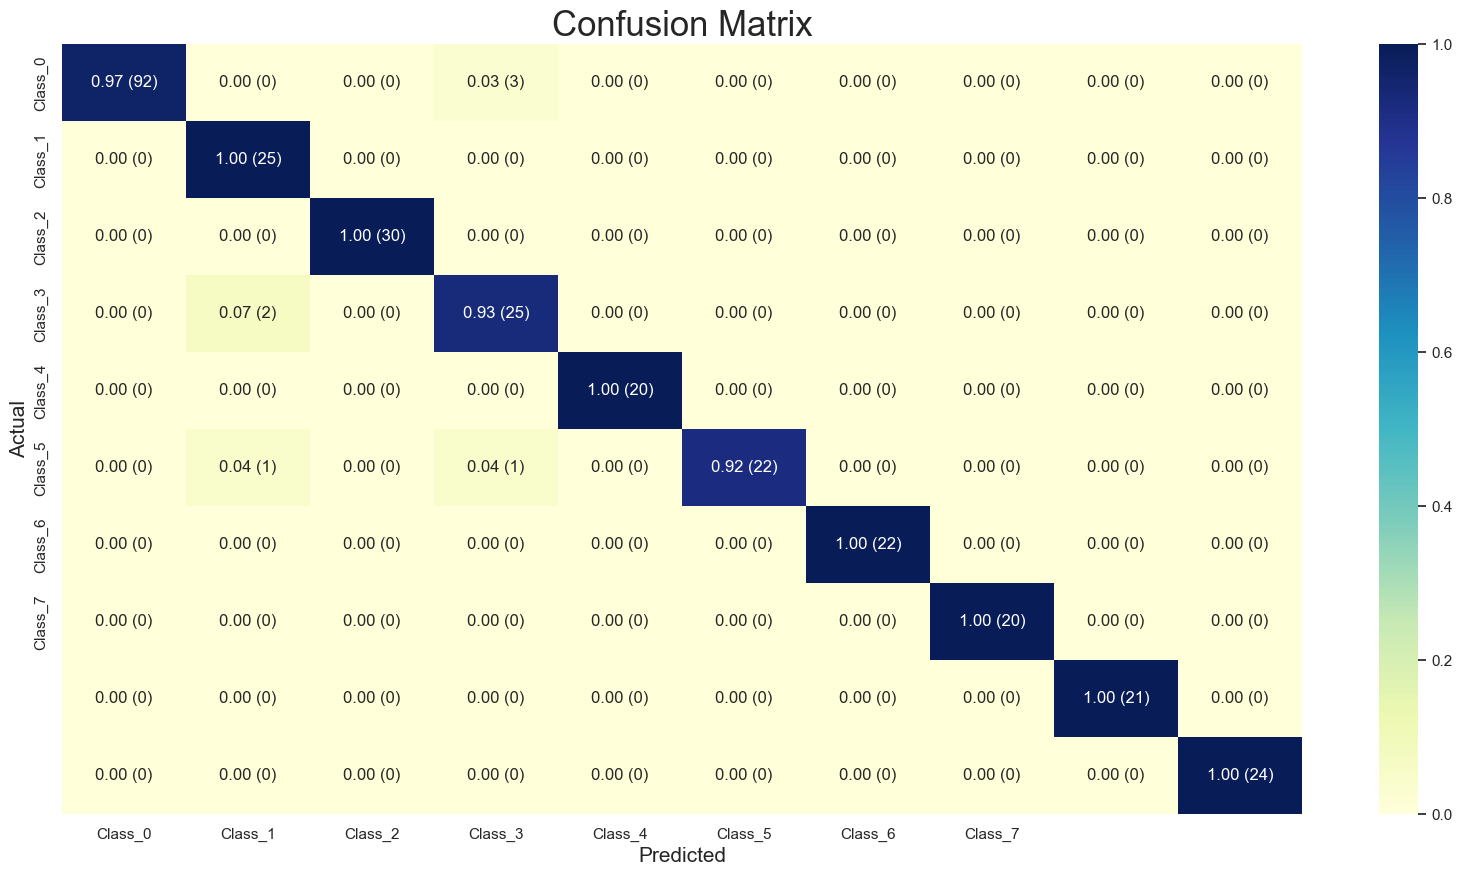

In [19]:
def plot_conf_mat(Ground_Truth_Labels, Predictions):
  confusion_matrix_raw = confusion_matrix(Ground_Truth_Labels, Predictions, normalize=None)
  confusion_matrix_norm = confusion_matrix(Ground_Truth_Labels, Predictions, normalize='true')
  shape = confusion_matrix_raw.shape
  data = np.asarray(confusion_matrix_raw, dtype=int)
  text = np.asarray(confusion_matrix_norm, dtype=float)
  annots = (np.asarray(["{0:.2f} ({1:.0f})".format(text, data) for text, data in zip(text.flatten(), data.flatten())])).reshape(shape[0],shape[1])
  fig = plt.figure(figsize=(20, 10))
  sns.heatmap(confusion_matrix_norm, cmap='YlGnBu', annot=annots, fmt='', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix', fontsize=25)
  plt.xlabel("Predicted", fontsize=15)
  plt.ylabel("Actual", fontsize=15)
#
plot_conf_mat(Y_test_, Y_Preds)

In [20]:
# Evaluating Overall Metrics - Accuracy, Precision, Recall, f1-Score
Accuracy = accuracy_score(Y_test_, Y_Preds)
Precision = precision_score(Y_test_, Y_Preds, average= 'weighted')
Recall = recall_score(Y_test_, Y_Preds, average= 'weighted')
f1_Score = f1_score(Y_test_, Y_Preds, average= 'weighted')
print(f'Accuracy = {Accuracy:.3f}')
print(f'Precision = {Precision:.3f}')
print(f'Recall = {Recall:.3f}')
print(f'f1-Score = {f1_Score:.3f}')

Accuracy = 0.977
Precision = 0.979
Recall = 0.977
f1-Score = 0.978
